## Feature selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [13]:
pics = './pics'
tables = './tables'

In [4]:
new_df = pd.read_csv(f'{tables}/all_desc.csv')

In [5]:
new_df.isnull().values.any()

False

In [28]:
X = new_df.iloc[:,:-1]
y = new_df.label
y

0        1
1        1
2        1
3        1
4        1
        ..
34787    0
34788    0
34789    0
34790    0
34791    0
Name: label, Length: 34792, dtype: int64

### Filtering invariant (1.13.1.) and highly correlated features

In [29]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.9
sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
X = sel.fit_transform(X)

# del_col = []
# for col in X.columns:
#     if len(X[col].unique()) == 1:
#         X.drop(col, inplace=True, axis=1)
#         del_col.append(col)
        

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X.drop(to_drop, axis=1, inplace=True)

In [8]:
from numpy import mean
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,f1_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.ensemble import RandomForestClassifier

import warnings

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
y_test.value_counts()

0    3170
1     310
Name: label, dtype: int64

### Feature selection using Random Forest Classifier

In [31]:
# Bagged decision trees for feature importance- embedded method
Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain = X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]
warnings.filterwarnings('ignore')

# Important scores
# for name, importance in zip(df_traindata, Rtree_clf.feature_importances_):
#     print(name, "=", importance)

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

#for f in range(200):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


In [32]:
print(len(importances[indices]))

166


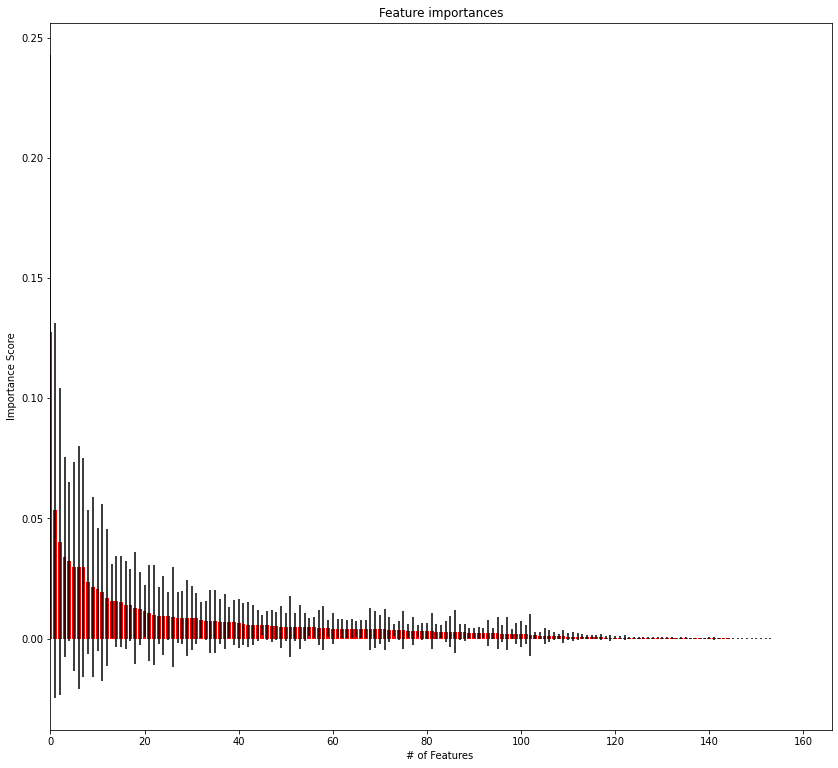

In [34]:
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(len(importances[indices])), importances[indices], color="r", yerr=std[indices], align="center")
plt.xlim([0, len(importances[indices])])
# plt.show()
plt.savefig(f'{pics}/rf_feat_import.png')

In [45]:
svc = svm.SVC(C=1, gamma=0.0001, random_state=0)
est = svc.fit(X_train, y_train)

### 1.13.3. Recursive Feature Elmination

In [16]:
from sklearn.feature_selection import RFECV, RFE

In [ ]:

# https://www.kaggle.com/code/arrohit/feature-selection-and-hypertuning-svm

# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications

# Before we apply RFE we need to know the optimal number of features. 
# Hence RFECV cross-validation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
# Stratified fold in order to reduce bias

def importance_getter(estimator, X, y):
    df = estimator.decision_function(X)
    importances = np.abs(df).mean(axis=0)  # Mean absolute value for each feature
    return importances / np.max(importances)  # Normalize for comparison

min_features_to_select = 10
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rfecv = RFECV(estimator=est, step=1, cv=cv, scoring='accuracy',
              n_jobs=-1, verbose=10, importance_getter=importance_getter, min_features_to_select=min_features_to_select)
rfetrain = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)


In [56]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# clf = RandomForestRegressor(n_estimators=100, max_depth=10)
clf = RandomForestClassifier(n_estimators=50, max_depth=10)
min_features_to_select = 50
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
    verbose=10
)

size = 6000
rfecv.fit(X[:size], y[:size])
print('Optimal number of features :', rfecv.n_features_)

Optimal number of features : 108


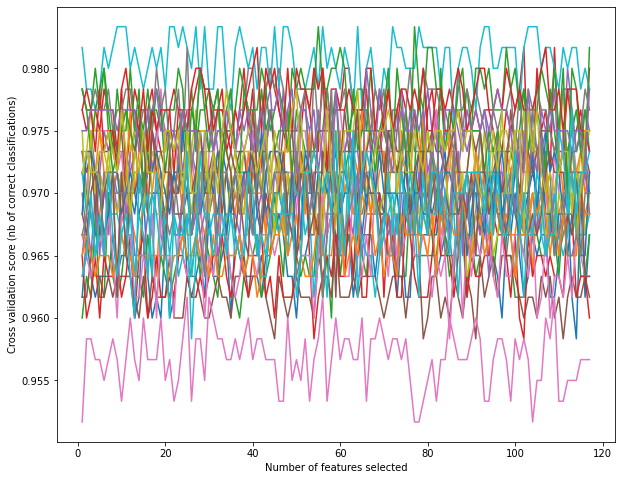

In [63]:
# Plot showing the Cross Validation score
fig, ax = plt.subplots(figsize=(10, 8))
# plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
# plt.show()
plt.savefig(f'{pics}/rfecv_feat.png')

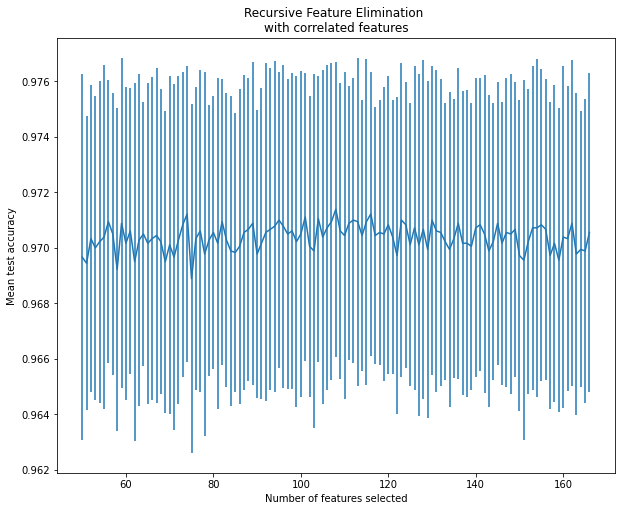

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Applying RFE with optimal number of features found in RFECV

In [ ]:
# svc = svm.SVC(C=1, gamma=0.0001, random_state=0)
# rfe = RFE(estimator=svc, n_features_to_select=rfecv.n_features_, step=1)

clf = RandomForestClassifier(n_estimators=50, max_depth=10)
rfe = RFE(estimator=clf, n_features_to_select=rfecv.n_features_, step=1)
rfe = rfe.fit(X_train, y_train)

rfe_train = X_train.loc[:, rfe.get_support()]
rfe_test = X_test.loc[:, rfe.get_support()]
# Checking the Accuracy after rfe
print("Train Accuracy:",cross_val_score(svc,rfe_train,y_train, cv=5).mean())

scv = svc.fit(rfe_train, y_train)
y_pred = scv.predict(rfe_test)
print("Test Accuracy:", accuracy_score(y_pred, y_test))

108

### Permutation importance

In [47]:
perm_importance = permutation_importance(svc, X_test, y_test, n_jobs=-1)

features = np.array(X.columns)

sorted_idx = perm_importance.importances_mean.argsort()

#### Plot top 10 important features

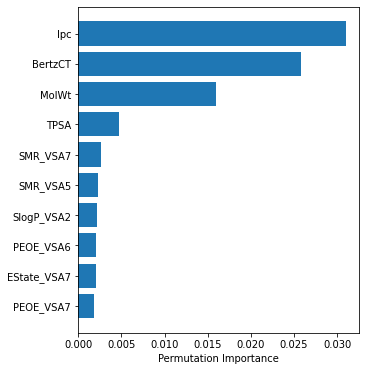

In [48]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top10_feat_perm.png')

#### Plot top 10 less important features

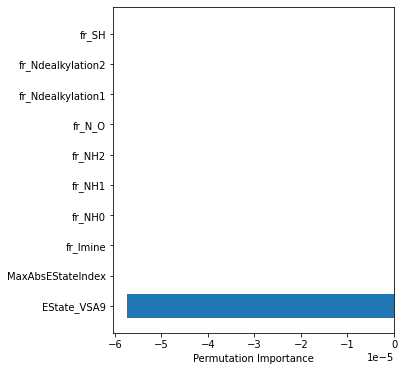

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.barh(features[sorted_idx][:10], perm_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
plt.gcf().subplots_adjust(left=0.25)
plt.savefig(f'{pics}/top-10_feat_perm.png')

In [27]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.337455,0.057778,-1.272753,0.255933,23.375000,505.329,0.320010,-0.463007,0.320010,1.250000,...,0,0,0,0,0,0,0,0,0,0
1,10.335047,0.059736,-1.271941,0.255933,23.375000,505.329,0.320010,-0.463007,0.320010,1.250000,...,0,0,0,0,0,0,0,0,0,0
2,10.333078,0.061184,-1.271281,0.255933,23.375000,505.329,0.320010,-0.463007,0.320010,1.250000,...,0,0,0,0,0,0,0,0,0,0
3,10.355554,0.205346,-1.235039,0.369988,25.218750,440.504,0.226290,-0.393567,0.226290,1.125000,...,0,0,0,0,0,0,0,0,0,0
4,6.090409,0.226017,0.226017,0.547921,12.285714,362.614,0.220767,-0.447724,0.220767,1.142857,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34787,12.933117,0.026874,-4.100987,0.602223,14.468750,461.496,0.338449,-0.495317,0.338449,1.156250,...,0,1,0,0,0,0,0,0,0,1
34788,5.666491,0.191419,0.191419,0.400631,19.187500,455.592,0.229469,-0.376386,0.229469,1.156250,...,0,0,0,0,0,0,0,0,0,0
34789,13.336315,0.076157,-3.927724,0.337664,12.322581,451.432,0.321296,-0.451565,0.321296,1.225806,...,0,1,0,0,0,0,0,0,0,0
34790,13.414551,0.220101,-4.286701,0.417596,25.687500,468.395,0.587160,-0.465029,0.465029,1.031250,...,0,0,0,0,0,0,0,0,0,0


### Finding the number of dimensions to transform using PCA

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components = len(X.columns))
pca_traindata = pca.fit(X_train)

In [41]:
pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

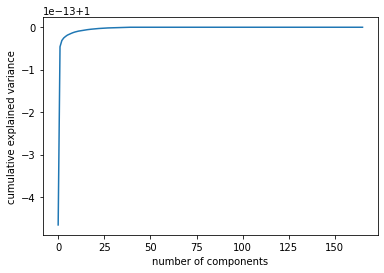

In [42]:
# Visualize PCA result
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(cum_ratio)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.savefig(f'{pics}/pca.png')

### Applying PCA with optimal number of features

In [38]:
pca = PCA(n_components = 100)
pca_traindata = pca.fit(X_train)

pcatrain = pca_traindata.transform(X_train)
pcatest = pca_traindata.transform(X_test)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

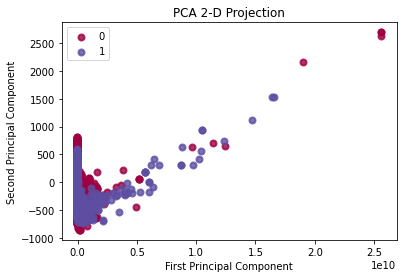

In [43]:
import scikitplot as skplt
skplt.decomposition.plot_pca_2d_projection(pca, X_train, y_train)
plt.savefig(f'{pics}/pc1pc2_relat.png')

### Hierarchical clustering on the Spearman rank-order correlations

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

#### https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [ ]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()